<img src="img/standardized-team4.jpg" width=1400 />

# A standardized framework to test event-based experiments: A tutorial
In the past decade, there has been a growing interest in improving scientific practices. Researchers have been enhancing their application of statistical testing, increasing their sample sizes, and stating their hypotheses a priori through pre-registration. However, these improvements rely on the assumption that the data have been properly collected. Surprisingly, little attention has been given to testing and reporting critical parameters of data collection. 

In our [paper](https://osf.io/preprints/psyarxiv/5ztnb), we describe a minimal protocol that can be followed to test all critical aspects of event-based experiments with minimal material and time investment. We also provide a shorthand report on [protocol.io](https://www.protocols.io/edit/testing-framework-protocol-cm8wu9xe) to ensure standardized reporting and documentation of experimental setup performance in a given experiment.

## Dummy experiment
To illustrate our framework, we created a dummy experiment. This experiment consists of a 2 by 2 design in which stimuli of different **shapes** (star and triangle) are presented for 2 different **durations** (1.0 and 1.5s), for a total of **4 experimental conditions** (star/1.0s, star/1.5s, triangle/1.0, triangle/1.5s), **each repeated 20 times**. Each trial lasts 2.0s, starting with the stimulus (presented for the specified duration) followed by a blank screen. In between each trial, a random inter-trial interval is drawn from a uniform distribution between 0.5 and 1.5s. 

## Learning objectives
In this notebook, we will cover all the steps presented in the framework, to the exception of peripheral integration, to keep things simple. By the end of this notebook, you will know the following:
- Prepare your experiment to run the framework
- Check the visual angle of your stimuli
- Check and report the experiment log files' accuracy
- Check and report the experimental setup timing accuracy

## Materials
In order to complete the framework, you will need the following devices (in parenthesis are the specific devices we used):
- Photodiode ([Brain vision photo-sensor](https://brainvision.com/products/photo-sensor/))
- Contact microphone ([Schaller Oyster S/P](https://www.thomann.de/gb/schaller_oyster_723.htm))
- Recording system for the photodiode ([ActiChamp EEG amplifier](https://www.brainproducts.com/solutions/actichamp/))
- Recording system for the microphone ([RME Fireface UC/UCX](https://rme-audio.de/de_fireface-ucx.html))

In what is described below, the photodiode signal was recorded on a separate computer via the EEG amplifier, while the contact microphone signal was recorded on the experimental PC through the soundcard. Your lab's specific setup might differ, but the key requirement is that both signals are recorded to a file. Adjust the setup according to your lab's hardware.

The numbering of each section in this notebook matches the sections in the [protocol.io](https://www.protocols.io/edit/testing-framework-protocol-cm8wu9xe)


In [1]:
# Authors: Alex Lepauvre <alex.lepauvre@ae.mpg.de>
#          Rony Hirschhorn <hirschhorn@mail.tau.ac.il>
# License: MIT-License

import math
import pandas as pd
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.io import wavfile
from pathlib import Path
from audioParsing import find_clicks

# 1. Testing preparation
To run the tests below, we recommend that the experiment is at a stage where it is ready to be delpoyed (i.e. run on actual participants). For the purpose of this testing framework, some adjustments must be made to the experimental script to record physical signals on the basis of which timing accuracy can be established.

<div class="alert alert-info"><h4>Note</h4><p> 
    The steps below have to be prepared before running the experiment.
</p></div>

## 1.1 Present the photodiode square to test timing accuracy
You should add a key functionality to your experiment: presenting a square that changes in luminance at the onset of the stimulus such that those changes in luminance can be measured through a photodiode. The photodiode will then capture the ground truth, i.e., the precise moment in time when the event was presented (the event timing). To do so, you will need to display a white square at the onset of each experimental event of interest, which then turns back to black. We recommend presenting it in one corner of the display, as exemplified in the figure below (small dark square on the top left corner).

The white square should remain on the screen for a few frames (e.g., two frames) before turning back to black. This brief duration ensures that each flash is distinct and easily identifiable in the signal for each event, while being long enough to be reliably detected.

In our framework, we recommend presenting this square for each event, including when a stimulus appears (**stimulus onset**), when it disappears (**stimulus offset**), and when an inter-trial interval (**ITI**) starts. This approach allows you to assess the duration of each interval in your experiment (stimuli duration, ITI duration) by taking the difference between successive flashes.

Note that responses are not included in these events. This is because the screen refresh rate is usually low (e.g., 60Hz), and as responses are not tied to this refresh rate, the timestamping would be imprecise. For responses, we will record the sound produced by the button press (see section 1.2)

<div style="text-align: center;">
    <img src="img/Screenshot.jpg" alt="Centered Image" width="500"/>
</div>

You can find an example on how to present such a square under [drawPhotodiode.m](https://github.com/Cogitate-consortium/ExperimentTestingFramework/blob/main/dummyExperiment/drawPhotodiode.m) in psychtoolbox.

## 1.2 Record keyboard press sound
You should add a functionality to record audio from a contact microphone to your script. By recording the sound produced by button press, you can parse the recorded audio file to extract the time at which a button press occured, that can then be compared against the recorded time of button press by your experimental software to test timing accuracy. You can find an example on how to do so with psychtoolbox in the script [dummyExperiment.m](https://github.com/Cogitate-consortium/ExperimentTestingFramework/blob/main/dummyExperiment/dummyExperiment.m) at line 48 to 56

# 2. Create a pre-defined response sequence
In our dummy experiment, participants are supposed to press the right arrow when they see a star and the left arrow when they see a triangle. To be able to test that the button being pressed matches the button being logged, we will execute the response sequence during our test run and compare it to what is being logged.
Here is the arbitrary response sequence we will perform for the first 15 trials:

| Trial | Button |
| :-: | :-: |
| 1 | Left |
| 2 | Left |
| 3 | Left |
| 4 | Left |
| 5 | Left |
| 6 | Right |
| 7 | Right |
| 8 | Right |
| 9 | Right |
| 10 | Right |
| 11 | Up |
| 12 | Up |
| 13 | Up |
| 14 | Up |
| 15 | Up |


# 3. Prepare for a test run:
## 3.1 Attach the photodiode
We will attach the photodiode recording device on top of the square that we have implemented, like so:
<div style="text-align: center;">
    <img src="img/PhotodiodePlacement.jpg" alt="Centered Image" width="500"/>
</div>

## 3.2 Place the contact microphone
We will attach the contact microphone on the keyboard used as response device, in close proximity to the key that we will use in our experiment:
<div style="text-align: center;">
    <img src="img/MicPlacement.jpg" alt="Centered Image" width="500"/>
</div>


## 3.3 Prepare to take notes of the presented events
In order to check that the information about the presented events recorded in the log files matches the events that actually occurred on the screen, you should take notes of what happens on the screen. These notes can then be compared to the information found in the log files to ensure that the information that is logged is correct

## 4. Visual angle check
The first aspect to check is the size of the stimuli in degrees of visual angle. As stated above, the star and triangle should occupy 6x6 degrees of visual angle, centered on the middle of the screen. To fullfil our protocol, the following measures must be obtained:
- Screen height and width in pixels
- Screen height and width in centimeters
- Distance between participants nasion and screen
- Stimulus heights and width in centimeters

<div style="text-align: center;">
    <img src="img/triangleHeight.jpg" alt="Centered Image" width="500"/>
    <img src="img/triangleWidth.jpg" alt="Centered Image" width="500"/>
</div>

For the two first, we recommend finding the model of the screen and finding the exact specifications. The distance between the participants nasion and the screen as well as the stimulus size in centimeters must be measured manually. In our case, the screen distance was of **60cm** and the measured height and width of each stimulus was of **6.1cm** (both in height and width). Based of these measurements, we can now compute the size of the stimuli in degrees of visual angle, like so:  

In [2]:
width_cm = 6.2
height_cm = 6.2
dist_cm = 60
# Compute the size of the stimulus in radians
size_rad = 2 * math.atan((width_cm/2) / dist_cm)
# Convert to degrees
size_dva = size_rad * (180.0 / math.pi)
print('The stimulus size was of {} d.v.a.'.format(size_dva))


The stimulus size was of 5.915304099416792 d.v.a.


As we can see, we are pretty close of the expected 6 degrees. All measured values can be entered in the protocol in section 4. In our experiment, the stimuli were presented centrally on the screen, without any eccentricity. We will therefore fill the form by specifying that the eccentricity is of 0 degrees. You should use the values collected above to fill the section 4 in the protocol.io:
<div style="text-align: center;">
    <img src="img/DVACheck.jpg" alt="Centered Image"/>
</div>

In case your experiment is presenting the stimuli off-center, here is an example of how you can compute it to report it. Say you want to present your stimuli in the top left quadrant of the screen, such that its center is located at 3 degree from the center vertically, and 4 degrees horizontally. You should measure the distance between the center of the screen and the center of the stimulus both horizontally and vertically, like so:
<div style="text-align: center;">
    <img src="img/x_eccentricity.jpg" alt="Centered Image" width="500"/>
    <img src="img/y_eccentricity.jpg" alt="Centered Image" width="500"/>
</div>

You can compute the eccentricity like so:

In [3]:
# Measured eccentrity
x_dist_center_cm = 4.2
y_dist_center_cm = 3.1
dist_cm = 60
# Horizontal eccentricity:
x_eccentricity_rad = math.atan(x_dist_center_cm / dist_cm)
x_eccentricity_dva = x_eccentricity_rad * (180.0 / math.pi)
# Vertical eccentricity:
y_eccentricity_rad = math.atan(y_dist_center_cm / dist_cm)
y_eccentricity_dva = y_eccentricity_rad * (180.0 / math.pi)
print('Horizontal eccentricity= {:.2f} d.v.a.'.format(x_eccentricity_dva))
print('Vertical eccentricity= {:.2f} d.v.a.'.format(y_eccentricity_dva))

Horizontal eccentricity= 4.00 d.v.a.
Vertical eccentricity= 2.96 d.v.a.


# 5. Controlled event content logging
The goal is to check that the events that are being logged match the events that were presented. Unfortunately, this is achieved by manually annotating the stimuli that one is seeing and comparing it to what is presented in the log file, which is a bit time consuming. But this only needs to be done once. 

To achieve this, we ran the experiment and manually noted what was presented on a piece of paper. We did so for 20 trials in a row:
| Trial | Shape | Logged shape |
| :-: | :-: |:-: |
| 1 | star |star |
| 2 | star |star |
| 3 | star |star |
| 4 | star |star |
| 5 | triangle |triangle |
| 6 | star |star |
| ... | ... | ... |

This was then compared to the information that was logged. As we can see, the two sequences are the same, so we know that the logging is correct. Note that we are ignoring the duration condition for now, this will be tested more thoroughly in the next section. We can now fill the section 5 of the protocol:
<div style="text-align: center;">
    <img src="img/LogFileContent.jpg" alt="Centered Image" width="500"/>
</div>

# Running the experiment
<div class="alert alert-info"><h4>Note</h4><p> 
    Collecting the data required to perform the subsequent test can all be acquired within a single experimental run
</p></div>

Once you have conducted the tests above, you should run your experiment once more, making sure to respond according to your plan response sequence. This should yield the following files:
- Behavioral log files
- Photodiode signal
- Audio signal

Based on these files, you can now test all remaining aspects of your experiment

# 6. Uncontrolled events logging
In step 2, you already prepared and executed the response sequence while running the experiment. You therefore know what was pressed, which you can now compare to the log file. Let's load the log file to check the recorded responses:

In [4]:
# Set path:
data_root = r"C:\Users\alexander.lepauvre\Documents\GitHub\ExperimentTestingFramework\dummyExperiment\TestData"
subID = "SX114"
# Load the log file:
log = pd.read_csv(Path(data_root, "sub-{}_ses-1_task-Dummy_events.csv".format(subID)))

# Print the logged responses:
print(log["response"].to_numpy()[0:15])

['left' 'left' 'left' 'left' 'left' 'right' 'right' 'right' 'right'
 'right' 'wrongKey' 'wrongKey' 'wrongKey' 'wrongKey' 'wrongKey']


According to the log file, the left key was pressed for the first 5 trials, then right for the next 5 trials and  then "wrongKey" for the next 5 trials. This corresponds to what is expected based on your planned response sequence as the button "up" does not correspond to any relevant response in the context of our experiment. You can fill section 6 in protocol.io:

<div style="text-align: center;">
    <img src="img/ResponseLoggingCheck.jpg" alt="Centered Image"/>
</div>

# 7. Controlled events timing
So far, we have been testing the experiment in terms of content: making sure that the stimuli are presented in the right way and that the correct content is being logged. Now, we will test that the timing of the events is correct. To that end, the experiment was run once in our lab. The experiement was programmed such that whenever a new event occured, a square turned from black to white. We placed a photodiode over this square, which enabled us to record physical changes on the screen at the onset of each new event. This recording can then be analyzed to test the timing accuracy of our experiment. We will here show how this is performed.
In our experiment, there are three events in each trial:
- Stimulus onset
- Stimulus offset
- Trial end/Start of the ITI

Using the photodiode, we can measure the actual occurrence of these events to ensure that our experiment is behaving properly in terms of timing. In other words, we want to make sure that the events occur at the time they are supposed to and last for as long as we expect them to last. 

In [5]:
# Loading the photodiode data:
raw = mne.io.read_raw_brainvision(Path(data_root, "{}.vhdr".format(subID)), preload=True)
photo_channel = "Fp1"

Extracting parameters from C:\Users\alexander.lepauvre\Documents\GitHub\ExperimentTestingFramework\dummyExperiment\TestData\SX114.vhdr...
Setting channel info structure...
Reading 0 ... 141299  =      0.000 ...   141.299 secs...


Once the data are loaded, the first step is to plot the photodiode signal. The signal should contain stark bursts corresponding to a change from the square being black to white, marking the onset of an event. By checking the signal, we can set a threshold to detect when the square was "on"

Text(0.5, 0, 'Time (s)')

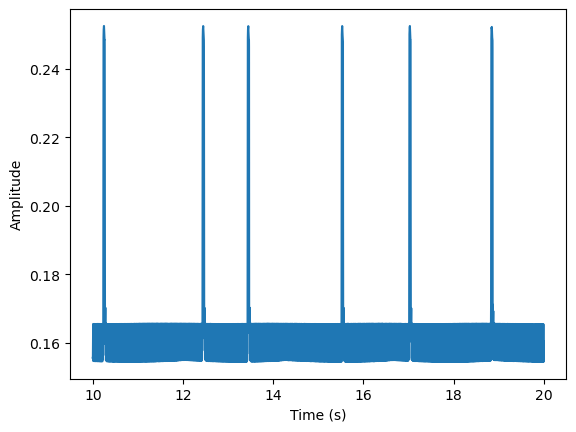

In [6]:
# Extract the photodiode signal:
pd_signal = np.squeeze(raw.get_data(picks=photo_channel))
# PLot part of the signal:
fig, ax = plt.subplots()
ax.plot(raw.times[10000:20000], pd_signal[10000:20000])
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time (s)")

We can clearly see the peaks in the signal above. There is quite some noise between 0.14 and 0.165 (units are mV), but the peaks are easily detected and setting a threshold at **0.18** ensures that we do not get false positives (i.e. detecting that the square was turned white when in fact is remained black). Based on this threshold, we can binarize the signal to clean it up.

Text(0.5, 1.0, 'Binarized photodiode signal')

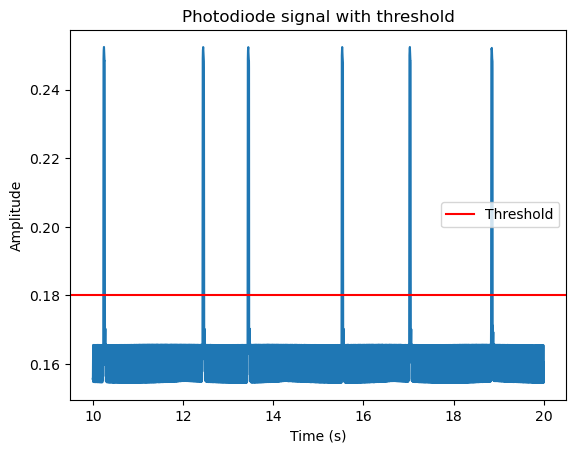

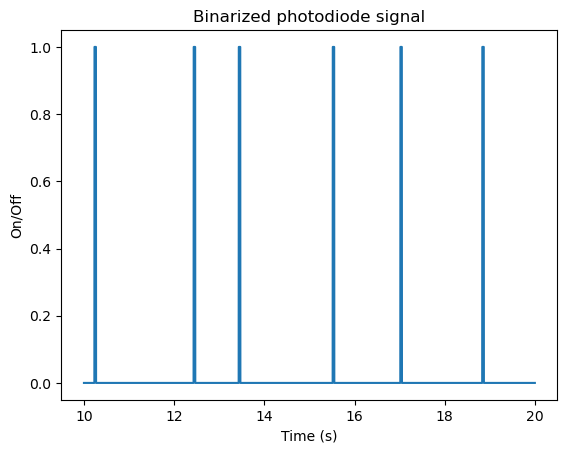

In [7]:
# Set our threshold:
thresh = 0.18

# Display the signal with the threshold:
fig, ax = plt.subplots()
ax.plot(raw.times[10000:20000], pd_signal[10000:20000])
ax.axhline(thresh, 0, 10000, c='r', label='Threshold')
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time (s)")
ax.set_title("Photodiode signal with threshold")
plt.legend()

# Binarizing the signal:
pd_bin = (pd_signal > thresh).astype(int)
fig, ax = plt.subplots()
ax.plot(raw.times[10000:20000], pd_bin[10000:20000])
ax.set_ylabel("On/Off")
ax.set_xlabel("Time (s)")
ax.set_title("Binarized photodiode signal")

Now that we have cleaned up the signal, we can detect the onset of each event. Remember that in our experiment, the square was flashed white at the beginning of each event and then turned black again after a bit. Therefore, the onset of a new stimulus can be identified by detecting when the photodiode signal turns "on". This is achieved very simply by taking the discrete difference of the binarized photodiode signal. This operation consists of subtracting from each sample the value of the previous sample. The binarized signal contains only ones and zeros, so the discrete difference can yield only 3 different values: 0 (no difference to previous sample), 1 (current sample is 1 while previous is 0) and -1 (current sample is 0 but previous sample is 1). We are only interested in the sample where the discrete difference yields a 1, as it corresponds to the time point where the square turned white.

Text(0.5, 1.0, 'Binarized photodiode signal')

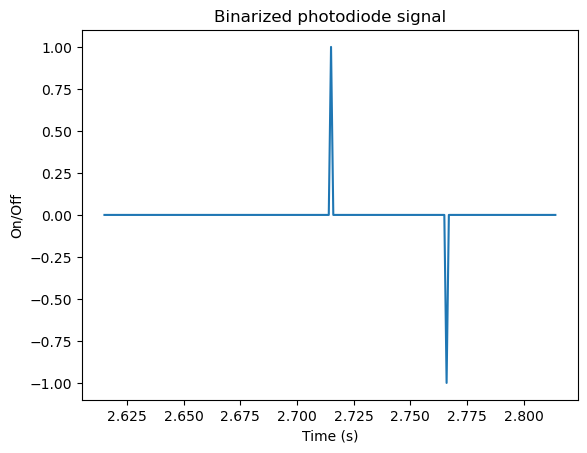

In [8]:
# Compute the discrete difference of the signal:
pd_diff = np.diff(pd_bin)
# Plot the signal to illustrate what that looks like:
fig, ax = plt.subplots()
ax.plot(raw.times[np.where(pd_diff==1)[0][0] - 100:np.where(pd_diff==1)[0][0] + 100], pd_diff[np.where(pd_diff==1)[0][0] - 100:np.where(pd_diff==1)[0][0] + 100])
ax.set_ylabel("On/Off")
ax.set_xlabel("Time (s)")
ax.set_title("Binarized photodiode signal")

As we can see, we have 2 peaks for this particular event: the first marks the transition of the photodiode from black to white and the other one marks the opposite. We can now obtain the time stamps of each events according to the photodiode like so

In [9]:
# Extract the times stamps  from the photodiode:
pd_ts = raw.times[np.where(pd_diff==1)[0]]

# Check that the length is the same as the log file:
print("{} events detected in the photodiode signal".format(pd_ts.shape[0]))
print("{} events present in the log file".format(log.shape[0] * 2))
assert log.shape[0] * 2 == pd_ts.shape[0], "Different number of events in the log file compared to the photodiode signal!"

80 events detected in the photodiode signal
80 events present in the log file


A mismatch between the number of detected photodiode triggers and the number of logged events could stem from the following issues:

- Noisy photodiode triggers, such that some triggers are missed or extra, incorrect triggers are picked up
- Incorrect implementation of the triggers, such that they aren't displayed when they should be
It cannot be due to the log file lacking some information, as we have tested it before.

Assuming all the above steps proceeded without any issues, we can now move on to the last step, in which we compute the interval between the events measured by the log files and compare it to the ground truth of the photodiode. To ensure that there are no misalignments between the two, we overlay the plot of the intervals of the log file with the plot of the photodiode output. If triggers are well align, the lines from the photodiode signal should overlap almost perfectly with the lines from the log file (as is seen in the figure below). If that is not the case, that might reflect one of the following issues:

- Triggers being detected at the wrong time, resulting in the correct number of triggers but with incorrect timing
- Entering the wrong sampling rate for the photodiode signal
- Not adjusting the duration of the events to match the screen refresh rate

Provided that there are no issues, then we can compare the intervals from the log file and from the photodiode to test the timing accuracy.

Text(0.5, 1.0, 'Timing inaccuaracies (Log - Photo)')

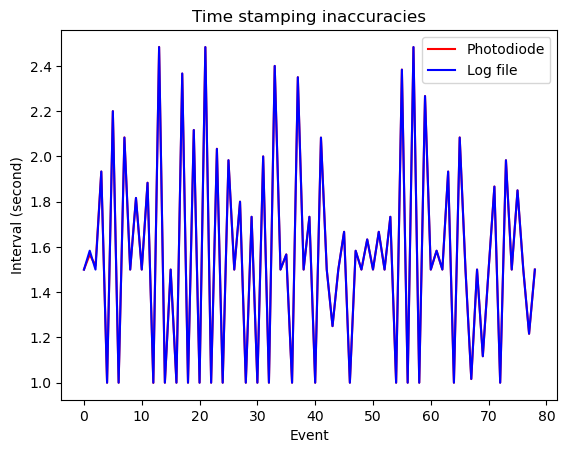

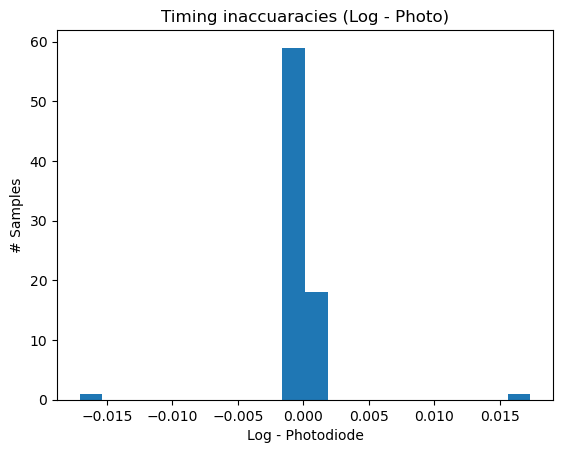

In [10]:
# Compute the intervals from both the photodiode and the log file:
pd_interval  = np.diff(pd_ts)
log_interval = np.diff(log[["stimOnset", "stimOffset"]].to_numpy().flatten())
# Overlay the two signals:
fig, ax = plt.subplots()
ax.plot(pd_interval, c="r", label="Photodiode")
ax.plot(log_interval, c="b", label="Log file")
ax.set_ylabel("Interval (second)")
ax.set_xlabel("Event")
ax.set_title("Time stamping inaccuracies")
plt.legend()

# Plot the distribution of the difference between the two:
fig, ax = plt.subplots()
ax.hist(log_interval - pd_interval, bins=20)
ax.set_ylabel("# Samples")
ax.set_xlabel("Log - Photodiode")
ax.set_title("Timing inaccuaracies (Log - Photo)")

As we can see, there  are some timestamping inaccuracies. To report them, we compute the mean and standard deviation of the interval difference. Then, we can fill the protocol:

In [11]:
mean_diff = np.mean(log_interval - pd_interval)
std_diff  = np.std(log_interval - pd_interval)
print("The timing inaccuracy is of {:.3f}+-{:.3f} sec.".format(mean_diff, std_diff))

The timing inaccuracy is of 0.000+-0.003 sec.


Based on all this information, you can now fill section 7 of the protocol:

<div style="text-align: center;">
    <img src="img/photodiodeThreshold.jpg" alt="Centered Image"/>
</div>

<div style="text-align: center;">
    <img src="img/LogTimingAccuracy.jpg" alt="Centered Image"/>
</div>

# 8. Uncontrolled events timing
The uncontrolled events refer to events that are not under the control of the experimental script but rather depend on user input, such as responses to a given stimulus. To obtain the reaction time to a particular event, the difference between the timestamp of an event and the timestamp of the corresponding button press are computed. The aim of the previous section was to ensure that the timestamps of the controlled events (i.e. stimulus presentation) are accurate. To make sure that the reaction time data is accurate, both the timestamping of the stimulus and of the button press should be accurate. The aim of this section is to test the accuracy of the button press timestamping. To that end, we recorded the sound associated with the button press using a contact microphone. In this section, we highlight the parsing of the audio file to extract the button press timestamps. This can then be compared with the timestamp of the button press recorded in the log file to estimate accuracy. 

Text(0.5, 0, 'Time (s)')

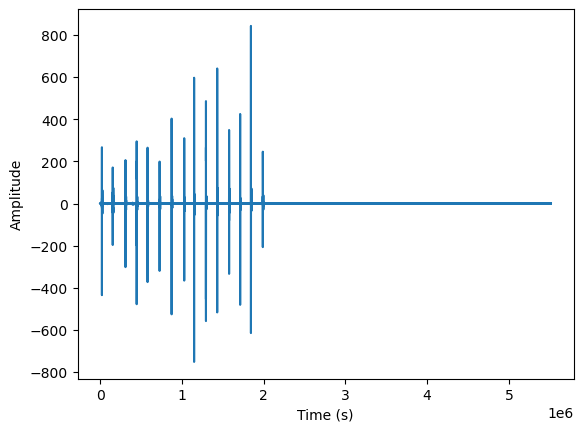

In [12]:
# Loading the audio data:
audio_file = Path(data_root, "sub-{}_ses-1_task-Dummy_audio.wav".format(subID))
sr, data = wavfile.read(audio_file)

# Plot the data:
fig, ax = plt.subplots()
ax.plot(data[:, 0])
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time (s)")

In the signal above, we can see 15 distinct peaks, corresponding to the 15 button presses performed as part of the planned response sequence. We will use similar tricks to the ones above to extract the onset of each of the button presses from the signal (though a bit more advanced, as audio signals are more complex than those of a photodiode). The steps are the same: we need to define a threshold for peak detection and then extract the time stamps for each of the peaks. Based on the plot above, we will use **100** (dB) as a threshold. In addition, the buttons were pressed only once per trial, we know that we should have at least 2 seconds in between each peak, which we will set as an extra parameter to avoid detecting a lot of extra peaks in between.

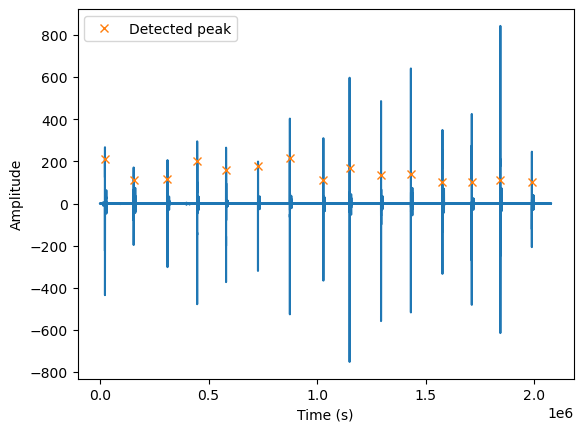

In [13]:
# Detect the peaks in the signal
peaks_samp, peaks_sec = find_clicks(data[:, 0], sr, 100, distance_s=0.5)
# Plot the detected peaks:
fig, ax = plt.subplots()
ax.plot(data[:peaks_samp[-1] + sr *2, 0])
ax.plot(peaks_samp, data[:, 0][peaks_samp], "x", label="Detected peak")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time (s)")
plt.legend()

Text(0.5, 1.0, 'Timing inaccuaracies (Log - Photo)')

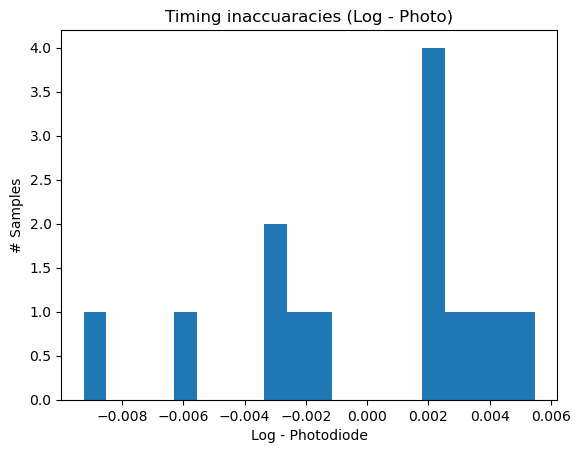

In [14]:
# Compute the interval between each button press from the recorded signal:
mic_interval = np.diff(peaks_sec)

# The reaction time was computed online by the experiment script. We can reconstruct the timestamps of the button press like so:
log_resp_onset = log.loc[log["rt"] != 0, "stimOnset"].to_numpy() + log.loc[log["rt"] != 0, "rt"].to_numpy() 
# Compute the interval recorded by the log file:
log_interval = np.diff(log_resp_onset)

# Plot the distribution of the difference between the two:
fig, ax = plt.subplots()
ax.hist(log_interval - mic_interval, bins=20)
ax.set_ylabel("# Samples")
ax.set_xlabel("Log - Photodiode")
ax.set_title("Timing inaccuaracies (Log - Photo)")

In [15]:
mean_diff = np.mean(log_interval - mic_interval)
std_diff  = np.std(log_interval - mic_interval)
print("The timing inaccuracy is of {:.3f}+-{:.3f} sec.".format(mean_diff, std_diff))

The timing inaccuracy is of -0.000+-0.004 sec.


As we can see from the histogram, there is quite a bit of jitter in the log file timestamping of the responses. This is not too surprising, given that to perform these tests, we used a normal computer keyboard, which does not have optimal performance. For experiments requiring highly precise reaction time data, it is important to consider using more sensitive devices, such as response boxes. Based on the information above, we can now fill the protocol.io section 8:

<div style="text-align: center;">
    <img src="img/UncontrolledEventsTimingCheck.jpg" alt="Centered Image"/>
</div>

<div style="text-align: center;">
    <img src="img/UncontrolledEventsTimingCheck2.jpg" alt="Centered Image"/>
</div>

## Validating the experimental design parameters
We are almost there. All the tests so far ensure that the information are precise and accurate both in terms of timing and content. The last thing we have to test is that the expected experimental design is indeed executed, which hasn't been explicitly tested so far. Here is what we will test here:
- Count of trials per condition
- Test the expected duration against the observed duration

### Count of trials
As we have tested the log file in previous steps, we can be confident that the information it contains truly reflects what occured in the experiment in terms of content. So we can simply count the number of events in each condition to make sure that the counts match what we expect. As stated at the beginning of the experiment, we have 4 conditions, each presented 20 times. We will check whether this is the case:

In [16]:
nTrials = log.shape[0]
count_df = log.groupby(['duration', 'shape']).size().reset_index(name='count')
print("N trials total = {}".format(nTrials))
print("N trials per condition")
print(count_df)

N trials total = 40
N trials per condition
   duration     shape  count
0       1.0      star     10
1       1.0  triangle     10
2       1.5      star     10
3       1.5  triangle     10


We have 20 trials for each of the conditions, which is in line with our expected experimental design. This can be reported in the protocol.io under section 9:
<div style="text-align: center;">
    <img src="img/TrialNumbersCheck.jpg" alt="Centered Image"/>
</div>

### Expected duration
Finally, we need to test whether the duration for which the events were presented matches the experimental design: we presented stimuli for either 1.0 or 1.5s. We need to make sure that the stimuli durations match what we want: if a stimulus should be present on the screen for 1.5s, we need to make sure that this is indeed the case. We have tested the log file timestamping to make sure that they are accurate. However, there may  always be some inaccuracies in log file timestamping. We recommend using the photodiode instead, as it constitutes the ground truth in terms of event timings. We will compare the duration of the stimuli that was observed in each of the trials against the duration that was expected from the log file:

The timing inaccuracy is of 0.000+-0.003 sec.


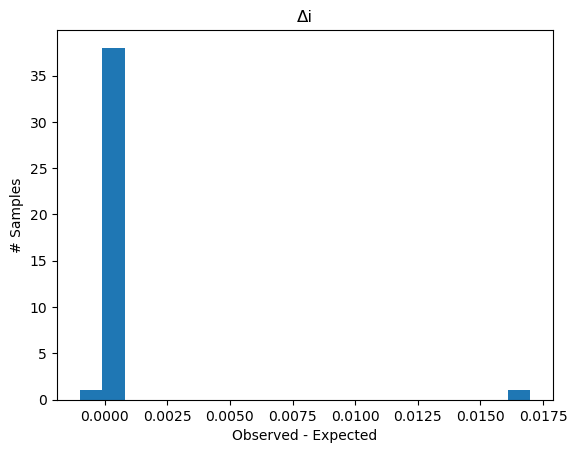

In [17]:
# Extract the observed duration of the stimuli. In our case, it is every second entry of the photodiode interval:
obs_duration = pd_interval[0::2]

# Compute the difference between the observed duration and the expected duration (deltai in our paper):
delta_i = obs_duration - log["duration"].to_numpy()

# Plot as a histogram:
fig, ax = plt.subplots()
ax.hist(delta_i, bins=20)
ax.set_ylabel("# Samples")
ax.set_xlabel("Observed - Expected")
ax.set_title("Δi")

# Compute the mean and the standard deviation. It should be close to 0:
mean_diff = np.mean(delta_i)
std_diff  = np.std(delta_i)
print("The timing inaccuracy is of {:.3f}+-{:.3f} sec.".format(mean_diff, std_diff))

As we can see, this is quite accurate. Most trials were displayed for exactly the duration we expected. In a few trials, the stimuli were displayed for ~16ms more than expected, which indicates that in a minority of the trials, one frame was skipped, which isn't too alarming. We can report the results of this test in section 10 of the protocol.io as follows:
<div style="text-align: center;">
    <img src="img/plannedDurationCheck.jpg" alt="Centered Image"/>
</div>

If needed for your purpose, you can go further and test whether the duration of additional events matches what you expect. In our experiment for example, each trial lasts for 2s plus some jitter (which was also logged). So the expected interval between each stimulus is therefore the 2s - the duration of the stimulus of that trial + the inter-trial interval. We can compare this  expected interval against the photodiode to make sure that the other events also have the correct duration:

The timing inaccuracy is of -0.000+-0.000 sec.


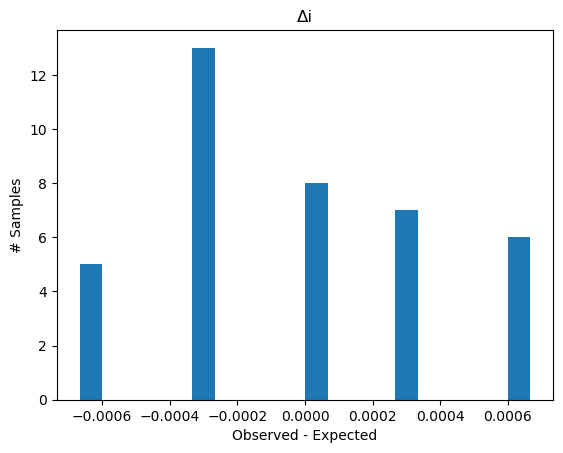

In [18]:
# Extract the observed duration of the stimuli. In this case, it is every second entry of the photodiode interval starting from 1 instead of 0:
obs_duration = pd_interval[1::2]
expected_duration = 2.0 - log["duration"].to_numpy() + log["iti"].to_numpy()
# Compute the difference between the observed duration and the expected duration (deltai in our paper):
delta_i = obs_duration - expected_duration[:-1]

# Plot as a histogram:
fig, ax = plt.subplots()
ax.hist(delta_i, bins=20)
ax.set_ylabel("# Samples")
ax.set_xlabel("Observed - Expected")
ax.set_title("Δi")

# Compute the mean and the standard deviation. It should be close to 0:
mean_diff = np.mean(delta_i)
std_diff  = np.std(delta_i)
print("The timing inaccuracy is of {:.3f}+-{:.3f} sec.".format(mean_diff, std_diff))

As we can see, this is even more precise, all differences are below a millisecond, which indicates that our experiment is very much in line with what will be reported in the method section of the paper!

# Exporting the results of the protocol:
Once you have performed the tests necessary for your purpose and filled out the protocol.io, you can export it as a pdf. You can find the example for the current experiment under [DummyExperimentTestingProtocol.pdf](https://github.com/Cogitate-consortium/ExperimentTestingFramework/blob/main/DummyExperimentTestingProtocol.pdf)

# Acknowledgments
This notebook is brought to you by the intracranial team of the COGITATE consortium.
<div style="display: flex; flex-wrap: wrap; justify-content: space-around;">
   <div style="text-align: center;">
      <a href="https://www.arc-cogitate.com/our-team" target="_blank">
         <img src="img/standardized-team1.jpg" alt="iEEG team">
      </a>
   </div>
</div>
<br />
We would like to thank all the COGITATE consortium members:
<div style="display: flex; flex-wrap: wrap; justify-content: space-around;">
   <div style="text-align: center;">
      <a href="https://www.arc-cogitate.com/our-team" target="_blank">
         <img src="img/IEEG DP Authors.jpg" alt="COGITATE team">
      </a>
   </div>
</div>
<img style="float: right;" src="img/templeton_logo.jpg" width=200;>
<br />
<br />

This research was supported by Templeton World Charity Foundation ([TWCF0389](https://doi.org/10.54224/20389)) and the Max Planck Society. The opinions expressed in this publication are those of the authors and do not necessarily reflect the views of TWCF.
